# Localized Entropy Notebook

This notebook runs the end-to-end pipeline using the config in `configs/default.json`.
Switch between synthetic and CTR data, tune the model, and toggle plots from the config file.


In [1]:
%matplotlib inline
import numpy as np
import torch

from localized_entropy.config import load_and_resolve, loss_label
from localized_entropy.utils import init_device, set_seed
from localized_entropy.data.pipeline import prepare_data
from localized_entropy.models import ConditionProbNet
from localized_entropy.training import train_with_epoch_plots, evaluate, predict_probs
from localized_entropy.analysis import (
    print_pred_summary,
    collect_le_stats_per_condition,
    collect_logits,
    bce_log_loss,
    expected_calibration_error,
    per_condition_metrics,
)
from localized_entropy.plotting import (
    plot_training_distributions,
    plot_eval_log10p_hist,
    plot_loss_curves,
    plot_eval_predictions_by_condition,
    plot_le_stats_per_condition,
    plot_ctr_filter_stats,
)

np.set_printoptions(precision=4, suppress=True)
torch.set_printoptions(precision=4)

CONFIG_PATH = "configs/default.json"
cfg = load_and_resolve(CONFIG_PATH)
print(f"Using experiment: {cfg['experiment'].get('name', cfg['experiment'].get('active', 'unknown'))}")

device, use_cuda, non_blocking = init_device()
set_seed(cfg['project']['seed'], use_cuda)


Using experiment: baseline
CUDA not available, defaulting to CPU.


Loading CTR dataset...
Train rows: 10,000,000 | Test rows: 4,577,464
Filtering to top 5 values of C14: [21767, 21768, 19251, 21790, 21611]
Filtered Train rows: 1,604,510 | Filtered Test rows: 4,577,464
Train/Eval DataLoader workers: 0/0 (pin_memory=False) | Test workers: 0 | DataLoader workers disabled (set allow_dataloader_workers=true to enable).
Top-filter stats (click):
       frequency  median       std
C14                               
21767     376105     0.0  0.304487
21768     373692     0.0  0.305673
19251     339308     0.0  0.267716
21790     280425     0.0  0.285710
21611     234980     0.0  0.240925


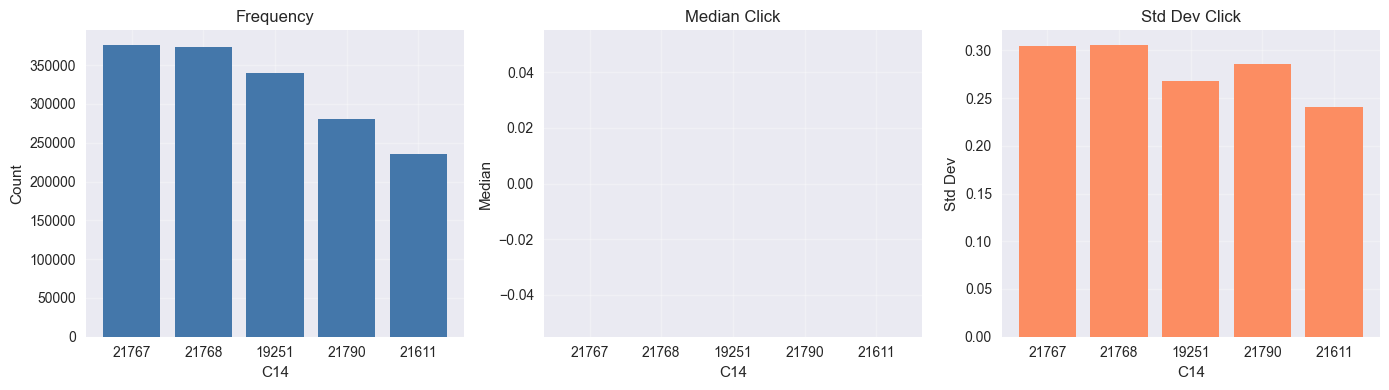

Skipping training data distribution plots before training.


In [2]:
data_bundle = prepare_data(cfg, device, use_cuda)
splits = data_bundle.splits
loaders = data_bundle.loaders
plots_cfg = cfg['plots']

if cfg.get('logging', {}).get('print_loader_note', True):
    print(loaders.loader_note)

if cfg.get('ctr', {}).get('plot_filter_stats', False):
    ctr_stats = data_bundle.plot_data.get('ctr_stats')
    if ctr_stats:
        plot_ctr_filter_stats(ctr_stats['stats_df'], ctr_stats['labels'], ctr_stats['filter_col'])

if plots_cfg.get('data_before_training', False):
    synth = data_bundle.plot_data.get('synthetic')
    if synth:
        plot_training_distributions(
            synth['net_worth'],
            synth['ages'],
            synth['probs'],
            synth['conds'],
            synth['num_conditions'],
        )
    else:
        print('Training distribution plots are only available for synthetic data.')
else:
    print('Skipping training data distribution plots before training.')


In [3]:
model_cfg = cfg['model']
num_numeric = splits.x_train.shape[1]
model = ConditionProbNet(
    num_conditions=splits.num_conditions,
    num_numeric=num_numeric,
    embed_dim=model_cfg['embed_dim'],
    hidden_sizes=tuple(model_cfg['hidden_sizes']),
    p_drop=model_cfg['dropout'],
).to(device)
model


ConditionProbNet(
  (embedding): Embedding(6, 16)
  (net): Sequential(
    (0): Linear(in_features=24, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [4]:
train_cfg = cfg['training']
train_losses, eval_losses = train_with_epoch_plots(
    model=model,
    train_loader=loaders.train_loader,
    val_loader=loaders.eval_loader,
    device=device,
    epochs=train_cfg['epochs'],
    lr=train_cfg['lr'],
    l2_weight_decay=train_cfg['l2_weight_decay'],
    non_blocking=non_blocking,
    plot_eval_hist_epochs=plots_cfg.get('eval_hist_epochs', False),
    loss_mode=train_cfg['loss_mode'],
)


Epoch   1/12 | Train LE: 0.000410 | Eval LE: 0.000334 | wall 14.53s
Epoch   2/12 | Train LE: 0.000240 | Eval LE: 0.000246 | wall 14.64s
Epoch   3/12 | Train LE: 0.000233 | Eval LE: 0.000251 | wall 14.77s
Epoch   4/12 | Train LE: 0.000242 | Eval LE: 0.000265 | wall 14.87s
Epoch   5/12 | Train LE: 0.000248 | Eval LE: 0.000267 | wall 14.84s
Epoch   6/12 | Train LE: 0.000250 | Eval LE: 0.000268 | wall 14.94s
Epoch   7/12 | Train LE: 0.000251 | Eval LE: 0.000270 | wall 14.89s
Epoch   8/12 | Train LE: 0.000252 | Eval LE: 0.000271 | wall 14.93s
Epoch   9/12 | Train LE: 0.000253 | Eval LE: 0.000271 | wall 15.05s
Epoch  10/12 | Train LE: 0.000252 | Eval LE: 0.000271 | wall 15.04s
Epoch  11/12 | Train LE: 0.000253 | Eval LE: 0.000271 | wall 15.04s
Epoch  12/12 | Train LE: 0.000253 | Eval LE: 0.000271 | wall 15.15s
Final Train LE: 0.0002525358
Final Eval  LE: 0.0002710602


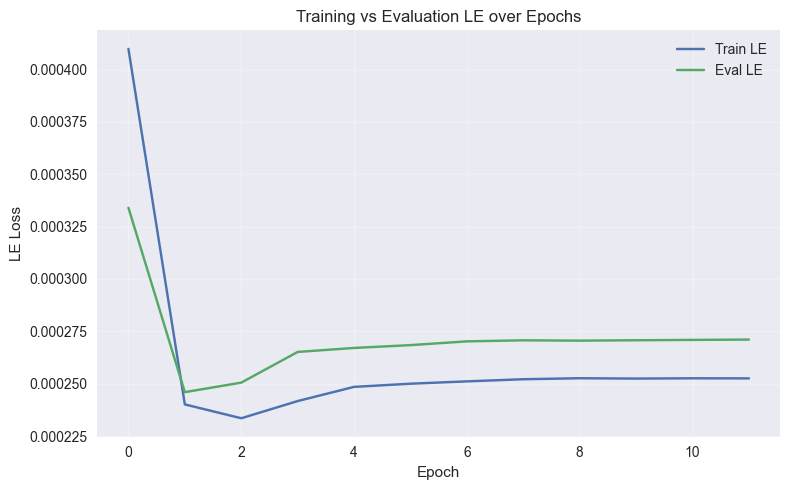

In [5]:
label = loss_label(train_cfg['loss_mode'])
if plots_cfg.get('loss_curves', True):
    plot_loss_curves(train_losses, eval_losses, label)


Eval prediction summary:
  n=160,451 mean=0.228681 std=0.000000
  min=0.228681 p01=0.228681 p05=0.228681 p50=0.228681 p95=0.228681 p99=0.228681 max=0.228681
  label base_rate=0.091330 | logloss=0.370690 | brier=0.101854 | acc@0.5=0.908670
  Top 8 conditions by count:
      count  pred_mean  label_mean
cond                              
0     37574   0.228681    0.104966
1     37405   0.228681    0.104772
2     33966   0.228681    0.079109
3     27929   0.228681    0.092019
4     23577   0.228681    0.065063


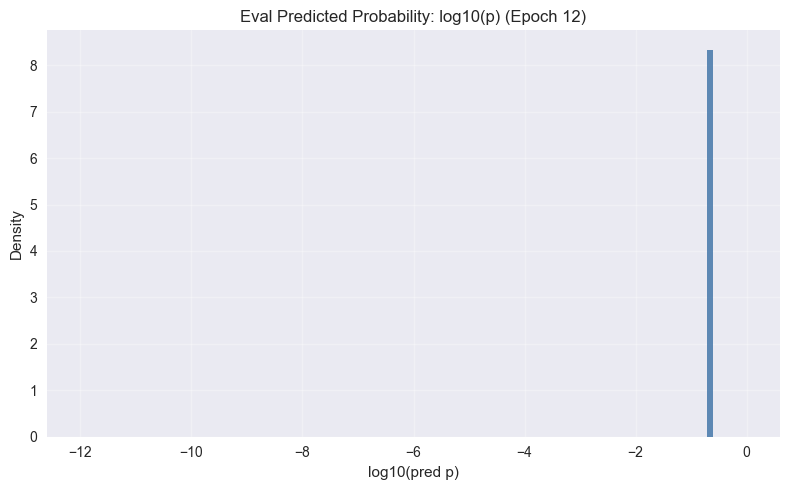

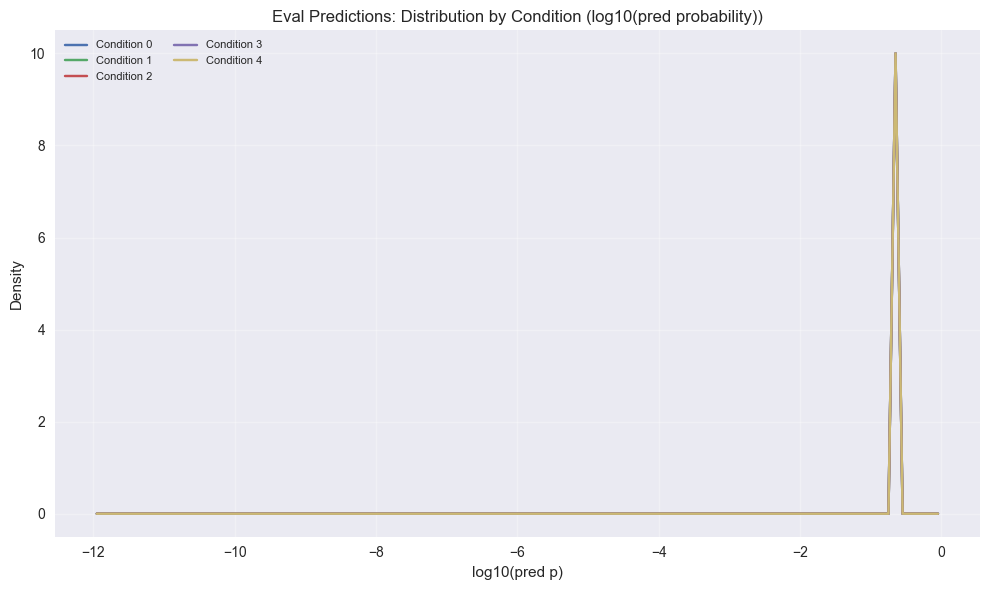

Final Evaluation LE: 0.0002710602
[INFO] No preds <= 0.01; using 0.10 quantile threshold 0.228681 for small-prob calibration.
Total BCE (log loss): 0.37069019
Total ECE: 0.13735123
Total ECE (small p<= 0.228681): 0.13735123
 condition  count  base_rate      bce      ece  ece_small
         0  37574   0.104966 0.387269 0.123715   0.123715
         1  37405   0.104772 0.387033 0.123909   0.123909
         2  33966   0.079109 0.355832 0.149573   0.149573
         3  27929   0.092019 0.371528 0.136662   0.136662
         4  23577   0.065063 0.338756 0.163618   0.163618
Final Evaluation BCE: 0.3706901845


In [6]:
eval_loss, eval_preds = evaluate(
    model,
    loaders.eval_loader,
    device,
    loss_mode=train_cfg['loss_mode'],
    non_blocking=non_blocking,
)
if plots_cfg.get('print_eval_summary', True):
    print_pred_summary('Eval', eval_preds, labels=splits.y_eval, conds=splits.c_eval)

if plots_cfg.get('eval_pred_hist', True):
    plot_eval_log10p_hist(eval_preds.astype(np.float32), epoch=train_cfg['epochs'])

if plots_cfg.get('eval_pred_by_condition', True):
    plot_eval_predictions_by_condition(eval_preds, splits.c_eval, splits.num_conditions)

print(f"Final Evaluation {label}: {eval_loss:.10f}")
eval_cfg = cfg.get('evaluation', {})
bins = int(eval_cfg.get('ece_bins', 20))
min_count = int(eval_cfg.get('ece_min_count', 1))
small_prob_max_cfg = float(eval_cfg.get('small_prob_max', 0.01))
small_prob_quantile = float(eval_cfg.get('small_prob_quantile', 0.1))

total_bce = bce_log_loss(eval_preds, splits.y_eval)
total_ece, total_ece_table = expected_calibration_error(
    eval_preds, splits.y_eval, bins=bins, min_count=min_count
)
small_threshold = small_prob_max_cfg
small_mask = eval_preds <= small_threshold
if not small_mask.any():
    quantile_threshold = float(np.quantile(eval_preds, small_prob_quantile))
    print(
        f"[INFO] No preds <= {small_threshold:g}; using {small_prob_quantile:.2f} quantile "
        f"threshold {quantile_threshold:g} for small-prob calibration."
    )
    small_threshold = quantile_threshold
    small_mask = eval_preds <= small_threshold

if small_mask.any():
    total_ece_small, _ = expected_calibration_error(
        eval_preds[small_mask],
        splits.y_eval[small_mask],
        bins=bins,
        min_count=min_count,
    )
else:
    total_ece_small = float('nan')

print(f"Total BCE (log loss): {total_bce:.8f}")
print(f"Total ECE: {total_ece:.8f}")
print(f"Total ECE (small p<= {small_threshold:g}): {total_ece_small:.8f}")

if eval_cfg.get('print_calibration_table', False):
    print(total_ece_table.to_string(index=False))

per_ad = per_condition_metrics(
    eval_preds,
    splits.y_eval,
    splits.c_eval,
    bins=bins,
    min_count=min_count,
    small_prob_max=small_threshold,
)
if eval_cfg.get('print_per_ad', True):
    top_k = int(eval_cfg.get('per_ad_top_k', 10))
    print(per_ad.head(top_k).to_string(index=False))

for mode in train_cfg.get('eval_compare_losses', []):
    if mode == train_cfg['loss_mode']:
        continue
    other_loss, _ = evaluate(
        model,
        loaders.eval_loader,
        device,
        loss_mode=mode,
        non_blocking=non_blocking,
    )
    other_label = loss_label(mode)
    print(f"Final Evaluation {other_label}: {other_loss:.10f}")


In [7]:
if loaders.test_loader is not None:
    test_preds = predict_probs(
        model,
        loaders.test_loader,
        device,
        non_blocking=non_blocking,
    )
    if test_preds.size > 0:
        if plots_cfg.get('print_eval_summary', True):
            print_pred_summary('Test', test_preds, labels=None, conds=splits.c_test)
    else:
        print('Test set is empty after filtering; skipping summary.')


Test prediction summary:
  n=4,577,464 mean=0.228681 std=0.000000
  min=0.228681 p01=0.228681 p05=0.228681 p50=0.228681 p95=0.228681 p99=0.228681 max=0.228681
  Top 8 conditions by count:
        count  pred_mean
cond                    
5     4518063   0.228681
4       59401   0.228681


In [8]:
if plots_cfg.get('data_after_training', False):
    synth = data_bundle.plot_data.get('synthetic')
    if synth:
        plot_training_distributions(
            synth['net_worth'],
            synth['ages'],
            synth['probs'],
            synth['conds'],
            synth['num_conditions'],
        )
    else:
        print('Post-training plots are only available for synthetic data.')
else:
    print('Post-training training data plots are disabled.')


Post-training plots are only available for synthetic data.


cond	num	den	avg_p	#y=1	#y=0	ratio
0	14551.2	12619.6	0.104966	3944	33630	1.15307
1	14477	12547.3	0.104772	3919	33486	1.15379
2	12086.2	9394.54	0.0791085	2687	31279	1.28651
3	10376.4	8579.35	0.092019	2570	25359	1.20946
4	7986.85	5674.47	0.0650634	1534	22043	1.40751


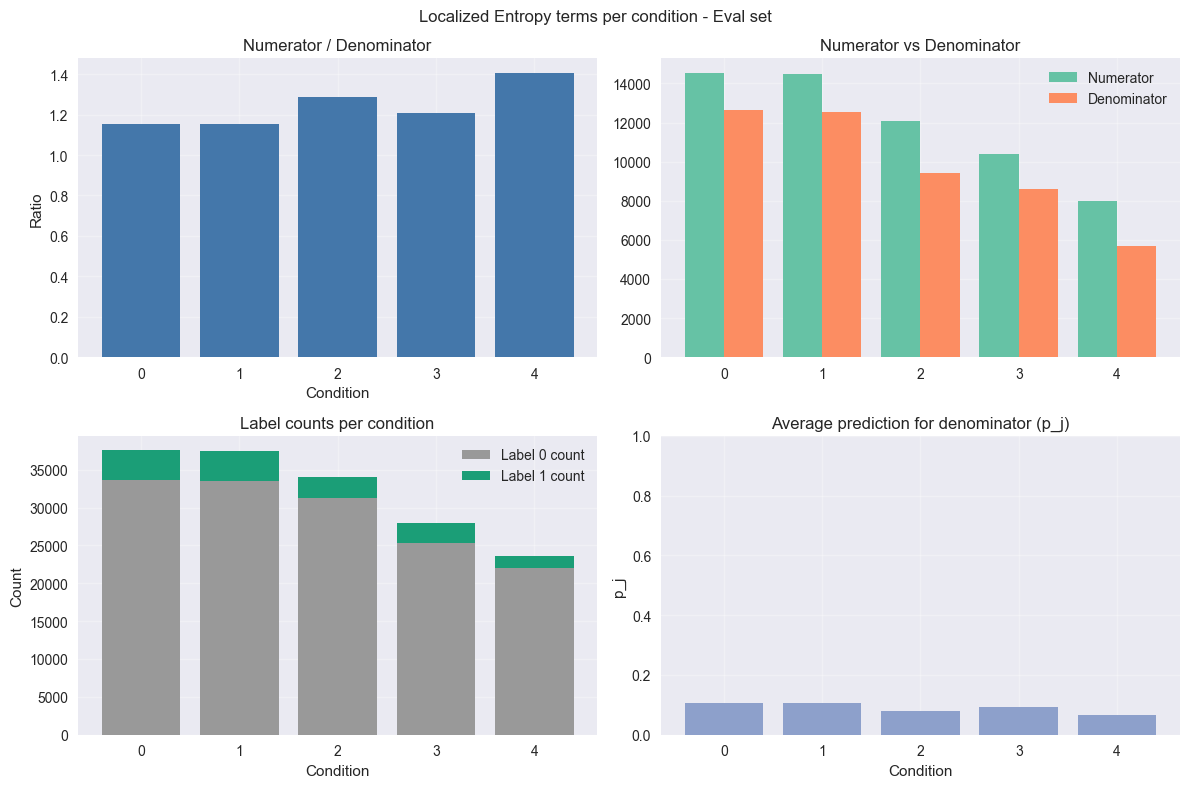

In [9]:
if plots_cfg.get('le_stats', True) or plots_cfg.get('print_le_stats_table', True):
    z_all, y_all, c_all = collect_logits(model, loaders.eval_loader, device, non_blocking=non_blocking)
    le_stats = collect_le_stats_per_condition(z_all, y_all, c_all, eps=1e-12)

    if plots_cfg.get('print_le_stats_table', True):
        print('cond	num	den	avg_p	#y=1	#y=0	ratio')
        for cond in sorted(le_stats.keys()):
            s = le_stats[cond]
            print(
                f"{cond}	{s['Numerator']:.6g}	{s['Denominator']:.6g}	"
                f"{s['Average prediction for denominator']:.6g}	"
                f"{s['Number of samples with label 1']}	"
                f"{s['Number of samples with label 0']}	"
                f"{s['Numerator/denominator']:.6g}"
            )

    if plots_cfg.get('le_stats', True):
        plot_le_stats_per_condition(le_stats, title='Localized Entropy terms per condition - Eval set')
